# Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style()
%matplotlib inline

In [2]:
df_invtry_new = pd.read_csv('../data/combined_tree_data_with_header_with_derived_neighborhood.csv')
df_invtry_new.head(1)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tree_id,survey_neighborhood,on_street_name,side,scientific_species_name,common_species_name,diameter_at_breast_height,condition,parkway_space_type,parkway_largest_dimension,trunks,maintenance_notes,status,hardscape_damage,observation_notes,clearance,longitude,latitude,derived_neighborhood
0,200610,Presidio Heights,GEARY BLVD,Front,Tristaniopsis laurina,Water Gum,3,Good,Well/Pit,3,1,Training Prune,1.0,None,None,None,-122.456872,37.781515,Laurel Heights / Jordan Park


---

# Tree Health

Look at the new inventory as it is most complete

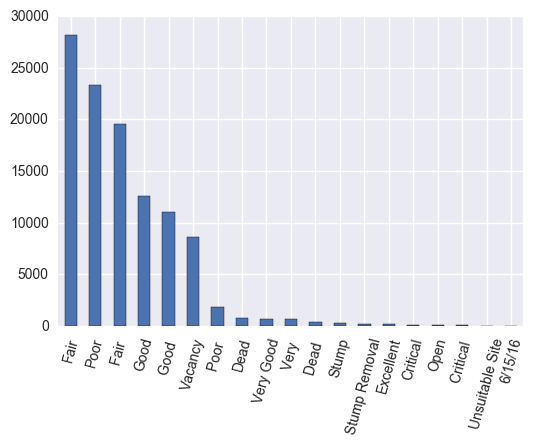

In [3]:
df_invtry_new.condition.value_counts().plot(kind='bar')
plt.xticks(rotation=75);

## Clean-up Labels

There are a number of problems with the above data. Cases and spaces are messing things up, so I'll throw out the stuff that isn't relevant and convert the related things.

Number of trees kept 98278 or 87.5 %


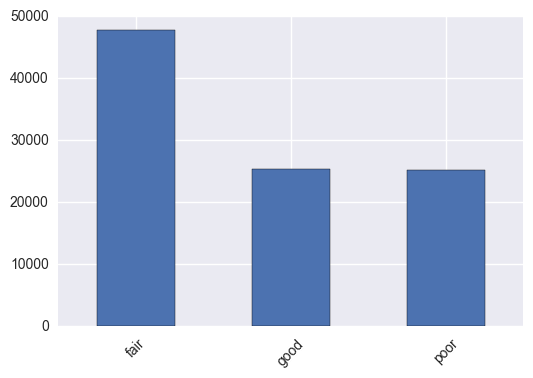

In [4]:
# Drop ones without a condition score
df_tree_cond = df_invtry_new.dropna(subset=['condition']).copy()

# Convert case of all condition scores
df_tree_cond.condition = df_tree_cond.condition.apply(lambda cond: cond.strip().lower())

# Combine similar condition scores and ignore all others
condition_map = {
    'excellent': 'good',
    'very good': 'good',
    'very': 'good',
    'good': 'good',
    'fair': 'fair',
    'poor': 'poor',
    'critial': 'poor',
}
df_tree_cond.condition = df_tree_cond.condition.map(condition_map)

# Drop the trees that were not mapped
df_tree_cond = df_tree_cond.dropna(subset=['condition'])

# Convert to neg score for poor and positive for good
df_tree_cond['condition_score'] = df_tree_cond.condition.map({'good': 1, 'fair': 0, 'poor': -1})

# Stats on the conversions
df_tree_cond.condition.value_counts().plot(kind='bar')
plt.xticks(rotation=45);

perc_kept = round(100.0 * df_tree_cond.shape[0] / df_invtry_new.shape[0], 1)
print 'Number of trees kept', df_tree_cond.shape[0], 'or', perc_kept, '%'

## Geography and Health

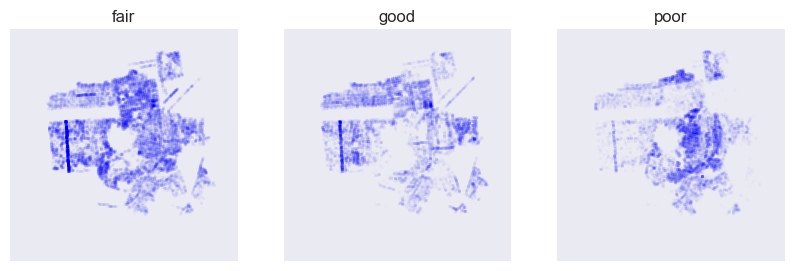

In [5]:
plt.figure(figsize=(10, 3))
for i, val in enumerate(df_tree_cond.groupby('condition')):
    cond, grp = val
    plt.subplot(1, 3, i+1)
    plt.title(cond)
    plt.scatter(grp.longitude, grp.latitude, marker='.', alpha=0.01, linewidths=0)
    plt.xticks([])
    plt.yticks([])

Interesting to see the separation of good and fair trees. Poor trees in the Mission stand out in particular as does the concentration of good trees in that one neighborhood in the Sunset.

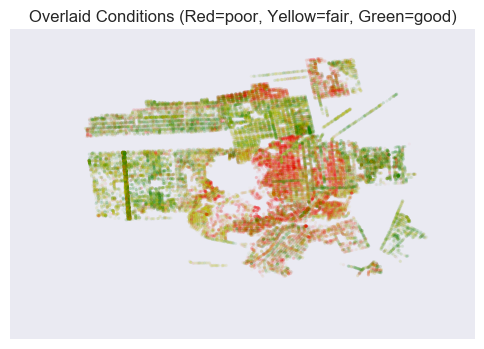

In [6]:
# Plot together
plt.title('Overlaid Conditions (Red=poor, Yellow=fair, Green=good)')
plt.scatter(df_tree_cond.longitude,
            df_tree_cond.latitude,
            c=df_tree_cond.condition.map({'fair': 'y', 'good': 'g', 'poor': 'r'}),
            marker='.',
            alpha=0.03,
            linewidths=0)
plt.xticks([]);
plt.yticks([]);

Based on the above it seems worthwhile to breakdown by geography. I'll start with the labels that I already have. I'll see if there is a correlation between health and neighborhood.

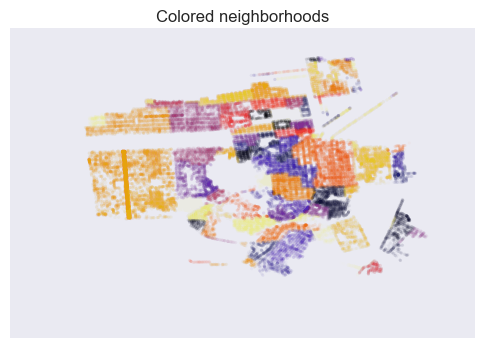

In [7]:
plt.title('Colored neighborhoods')
plt.scatter(df_tree_cond.longitude,
            df_tree_cond.latitude,
            c=df_tree_cond.derived_neighborhood.astype('category').cat.codes,
            cmap='CMRmap',
            marker='.',
            alpha=0.03,
            linewidths=0)
plt.xticks([]);
plt.yticks([]);

It looks like there is a diversity of neighborhoods, so I'll see how condition score compares

In [8]:
# TODO linear regression

Mean condition score 0.000986996072366


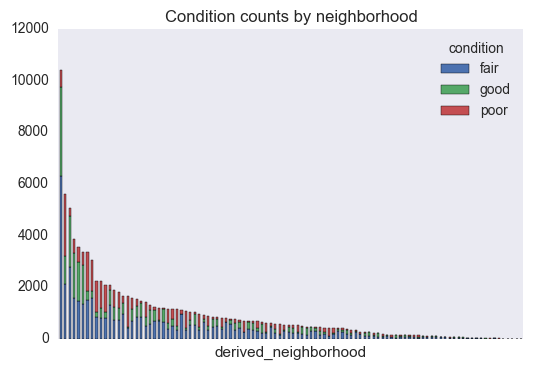

In [9]:
print 'Mean condition score', df_tree_cond.condition_score.mean()

# Compute neighborhood stats
df_nbr_stats = df_tree_cond.groupby(['derived_neighborhood', 'condition']).count().tree_id
df_nbr_stats = df_nbr_stats.unstack(fill_value=0)
df_nbr_stats['total'] = df_nbr_stats.sum(axis=1)
df_nbr_stats['p_fair'] = df_nbr_stats['fair'] / df_nbr_stats['total']
df_nbr_stats['p_good'] = df_nbr_stats['good'] / df_nbr_stats['total']
df_nbr_stats['p_poor'] = df_nbr_stats['poor'] / df_nbr_stats['total']
df_nbr_stats = df_nbr_stats.sort_values('total', ascending=False)


# Plot coounts by neighborhood and condition
df_nbr_stats[['fair', 'good', 'poor']].plot(kind='bar', stacked=True, grid=False)
plt.xticks([])
plt.title('Condition counts by neighborhood');

I'll look at the proportions of good and bad scores with a cutoff based on neighborhood size. Based on the above chart I'll cutoff at 300 trees.

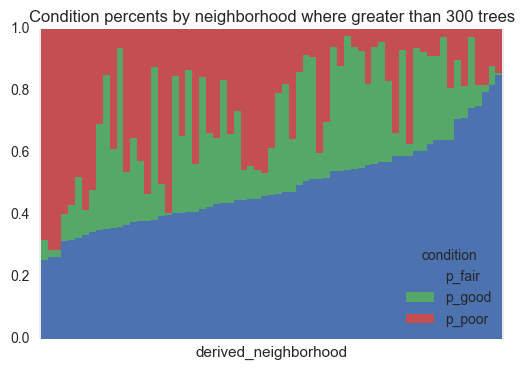

In [10]:
df_top_nbr = df_nbr_stats[df_nbr_stats.total > 300]
df_top_nbr[['p_fair', 'p_good', 'p_poor']].sort_values('p_fair').plot(kind='bar',
                                                                        width=1,
                                                                        linewidth=0,
                                                                        stacked=True,
                                                                        grid=False);
plt.xticks([])
plt.ylim((0, 1))
plt.title('Condition percents by neighborhood where greater than 300 trees');

In [11]:
# Top performing neighborhoods
df_best = df_top_nbr.sort_values('p_good', ascending=False).head(10)
df_best_trees = df_tree_cond[df_tree_cond.derived_neighborhood.apply(lambda n: n in df_best.index)]
df_best

condition,fair,good,poor,total,p_fair,p_good,p_poor
derived_neighborhood,,,,,,,
Central Waterfront,183,292,32,507,0.360947,0.575937,0.063116
Sutro Heights,169,235,71,475,0.355789,0.494737,0.149474
Dogpatch,248,320,80,648,0.382716,0.493827,0.123457
Potrero Hill,1584,1761,514,3859,0.410469,0.456336,0.133195
Inner Richmond,1364,1496,509,3369,0.404868,0.444049,0.151083
Bayview,648,516,26,1190,0.544538,0.433613,0.021849
Outer Richmond,1487,1505,551,3543,0.419701,0.424781,0.155518
Japantown,346,276,57,679,0.509573,0.406480,0.083947
Cathedral Hill,208,154,22,384,0.541667,0.401042,0.057292


In [12]:
# Worst performing neighborhoods
df_worst = df_top_nbr.sort_values('p_poor', ascending=False).head(10)
df_worst_trees = df_tree_cond[df_tree_cond.derived_neighborhood.apply(lambda n: n in df_worst.index)]
df_worst

condition,fair,good,poor,total,p_fair,p_good,p_poor
derived_neighborhood,,,,,,,
Eureka Valley,438,36,1184,1658,0.264174,0.021713,0.714113
Diamond Heights,113,10,304,427,0.264637,0.023419,0.711944
Upper Market,143,36,383,562,0.254448,0.064057,0.681495
Duboce Triangle,336,94,637,1067,0.314902,0.088097,0.597001
Miraloma Park,281,4,418,703,0.399716,0.005690,0.594595
Castro,212,51,369,632,0.335443,0.080696,0.583861
Glen Park,364,130,649,1143,0.318460,0.113736,0.567804
Pacific Heights,848,200,1188,2236,0.379249,0.089445,0.531306
Nob Hill,332,130,501,963,0.344756,0.134995,0.520249


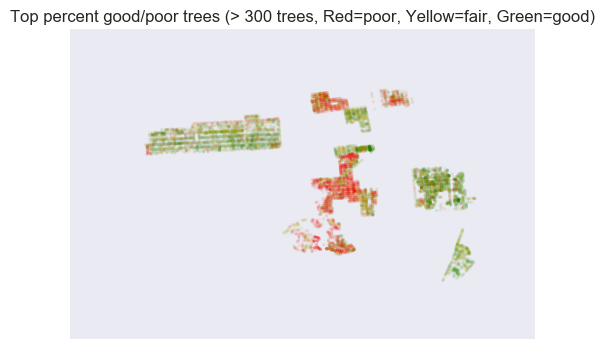

In [13]:
# Plot on a map
df_extreems = pd.concat([df_best_trees, df_worst_trees])
plt.title('Top percent good/poor trees (> 300 trees, Red=poor, Yellow=fair, Green=good)')
plt.scatter(df_extreems.longitude,
            df_extreems.latitude,
            c=df_extreems.condition.map({'fair': 'y', 'good': 'g', 'poor': 'r'}),
            marker='.',
            alpha=0.03,
            linewidths=0)
plt.xticks([])
plt.yticks([]);

This is interesting to see. I would expect certain areas of the city to get better scores than others but it it weird to see low and high performing neighborhoods in clos poximity. Perhaps there was some bias when the trees were counted and rated?

# Tree Health and Species/Genus

Breakdown by type of tree now as well to see if there is anything going on there

Most species are not very abundant. There are also a lot of them. I'll select the top most popular species.

In [14]:
cnts = df_tree_cond.scientific_species_name.value_counts()
cnts = cnts.sort_values(ascending=False)
print 'Num species', cnts.shape[0]

top_species = cnts[cnts > 300]
df_top_species = df_tree_cond[df_tree_cond.scientific_species_name.apply(lambda s: s in top_species.index)]
df_top_species.scientific_species_name.value_counts().shape

Num species 644


(63,)

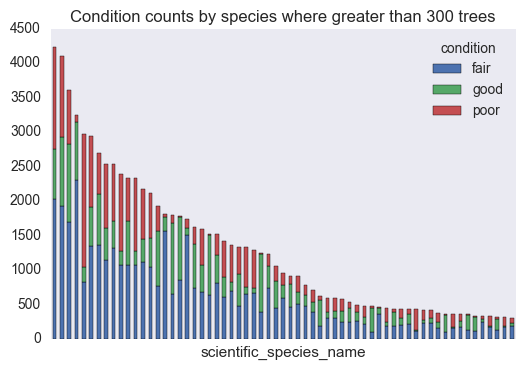

In [15]:
# Compute species stats
df_species_stats = df_top_species.groupby(['scientific_species_name', 'condition']).count().tree_id
df_species_stats = df_species_stats.unstack(fill_value=0)
df_species_stats['total'] = df_species_stats.sum(axis=1)
df_species_stats['p_fair'] = df_species_stats['fair'] / df_species_stats['total']
df_species_stats['p_good'] = df_species_stats['good'] / df_species_stats['total']
df_species_stats['p_poor'] = df_species_stats['poor'] / df_species_stats['total']
df_species_stats = df_species_stats.sort_values('total', ascending=False)


# Plot coounts by neighborhood and condition
df_species_stats[['fair', 'good', 'poor']].plot(kind='bar', stacked=True, grid=False)
plt.xticks([])
plt.title('Condition counts by species where greater than 300 trees');

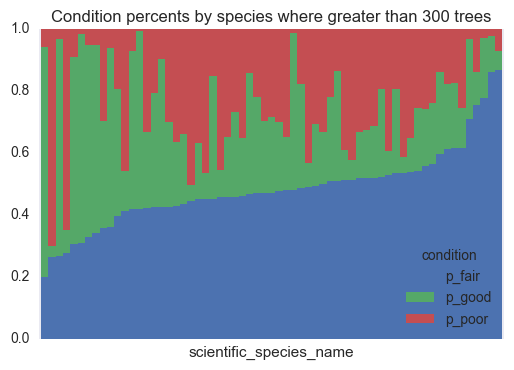

In [16]:
df_species_stats[['p_fair', 'p_good', 'p_poor']].sort_values('p_fair').plot(kind='bar',
                                                                        width=1,
                                                                        linewidth=0,
                                                                        stacked=True,
                                                                        grid=False);
plt.xticks([])
plt.ylim((0, 1))
plt.title('Condition percents by species where greater than 300 trees');

In [17]:
# Top performing species
df_species_stats.sort_values('p_good', ascending=False).head(10)

condition,fair,good,poor,total,p_fair,p_good,p_poor
scientific_species_name,,,,,,,
Washingtonia robusta,95,351,28,474,0.200422,0.740506,0.059072
Magnolia grandiflora 'Little Gem',98,256,12,366,0.267760,0.699454,0.032787
Arbutus x marina,388,842,22,1252,0.309904,0.672524,0.017572
Yucca gloriosa,110,207,17,334,0.329341,0.619760,0.050898
Phoenix canariensis,123,219,19,361,0.340720,0.606648,0.052632
Tristaniopsis laurina 'Elegant',192,378,56,626,0.306709,0.603834,0.089457
Prunus serrulata,647,1038,109,1794,0.360647,0.578595,0.060758
Tristania conferta,642,873,12,1527,0.420432,0.571709,0.007859
Acer rubrum,134,162,23,319,0.420063,0.507837,0.072100


In [18]:
# Worst performing species
df_species_stats.sort_values('p_poor', ascending=False).head(10)

condition,fair,good,poor,total,p_fair,p_good,p_poor
scientific_species_name,,,,,,,
Ficus microcarpa,114,14,301,429,0.265734,0.032634,0.701632
Platanus x acerifolia,819,229,1922,2970,0.275758,0.077104,0.647138
Syzygium paniculatum,161,19,183,363,0.443526,0.052342,0.504132
Acacia melanoxylon,1078,202,1108,2388,0.451424,0.084590,0.463987
Acacia baileyana,182,57,203,442,0.411765,0.128959,0.459276
Ficus microcarpa 'Nitida',1066,210,1059,2335,0.456531,0.089936,0.453533
Corymbia ficifolia,652,103,572,1327,0.491334,0.077619,0.431047
Myoporum laetum,664,80,548,1292,0.513932,0.061920,0.424149
Eucalyptus sideroxylon,175,16,135,326,0.536810,0.049080,0.414110


## Species Diversity

Look at some top best/worst species and their locations in the city

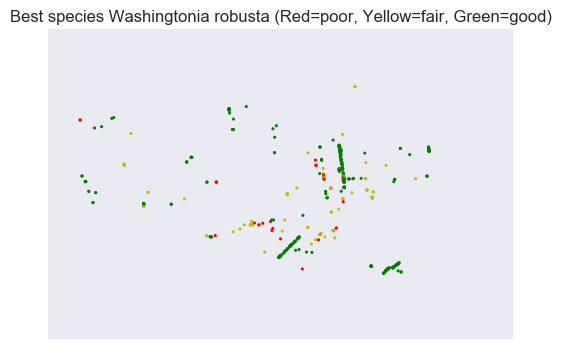

In [19]:
species = df_species_stats.sort_values('p_good', ascending=False).head(1).index[0]
df = df_tree_cond[df_tree_cond.scientific_species_name == species]
plt.title('Best species ' + species + ' (Red=poor, Yellow=fair, Green=good)')
plt.scatter(df.longitude,
            df.latitude,
            c=df.condition.map({'fair': 'y', 'good': 'g', 'poor': 'r'}),
            marker='.',
            linewidths=0)
plt.xticks([])
plt.yticks([]);

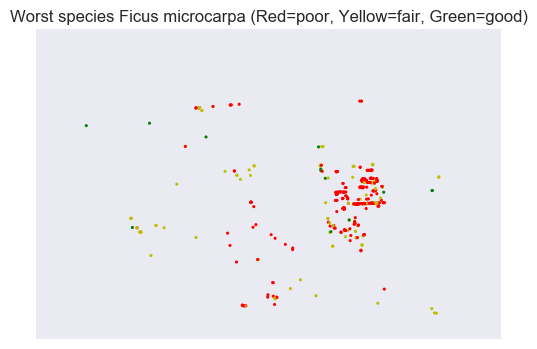

In [20]:
species = df_species_stats.sort_values('p_poor', ascending=False).head(1).index[0]
df = df_tree_cond[df_tree_cond.scientific_species_name == species]
plt.title('Worst species ' + species + ' (Red=poor, Yellow=fair, Green=good)')
plt.scatter(df.longitude,
            df.latitude,
            c=df.condition.map({'fair': 'y', 'good': 'g', 'poor': 'r'}),
            marker='.',
            linewidths=0)
plt.xticks([])
plt.yticks([]);

---

# Basic Recommender

First iteration is based on nearest neighbors. Recommend the most common species nearby.

Further iterations will take into account:
- Weight by condition score
- Weight by diversity (aka look for things that are not too common in the immediate area)

In [21]:
# Value ranges
lat_mn = df_tree_cond.latitude.min()
lat_mx = df_tree_cond.latitude.max()
lng_mn = df_tree_cond.longitude.min()
lng_mx = df_tree_cond.longitude.max()

N = 100
grid_lat = (lat_mx - lat_mn) / N
grid_lng = (lng_mx - lng_mn) / N

def geo(n_lat, n_lng):
    """0-99 in lat/long grid"""
    return [n_lat * grid_lat + lat_mn, n_lng * grid_lng + lng_mn]
geo(0, 0), geo(N-1, N-1)

([37.708305809999999, -122.5109011], [37.805686486799999, -122.379963304])

In [22]:
import scipy as sp
knn = sp.spatial.KDTree(df_tree_cond[['latitude', 'longitude']])

grid = np.array([geo(lat, lng) for lat in range(N) for lng in range(N)])
grid

array([[  37.70830581, -122.5109011 ],
       [  37.70830581, -122.5095785 ],
       [  37.70830581, -122.50825589],
       ..., 
       [  37.80568649, -122.38260851],
       [  37.80568649, -122.38128591],
       [  37.80568649, -122.3799633 ]])

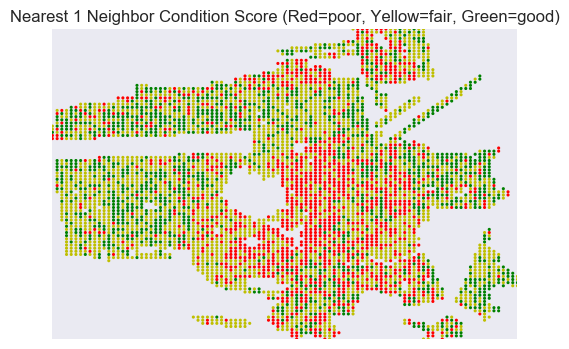

In [23]:
# Get condition scores across the city
dist, nearest_tree = knn.query(grid)
condition = df_tree_cond.iloc[nearest_tree].condition
clr = condition.map({'fair': 'y', 'good': 'g', 'poor': 'r'})

def map_nearest_tree(title, clr, dist, cmap=None):
    plt.title(title)
    
    # Take only nearby dist
    max_dist = dist < 0.001
    plt.scatter(grid[max_dist][:, 1],
                grid[max_dist][:, 0],
                c=clr[max_dist],
                cmap=cmap,
                marker='.',
                linewidths=0)
    plt.xlim(geo(0, 0)[1], geo(N-1, N-1)[1])
    plt.ylim(geo(0, 0)[0], geo(N-1, N-1)[0])
    plt.xticks([])
    plt.yticks([]);

map_nearest_tree('Nearest 1 Neighbor Condition Score (Red=poor, Yellow=fair, Green=good)',
                 clr, dist)

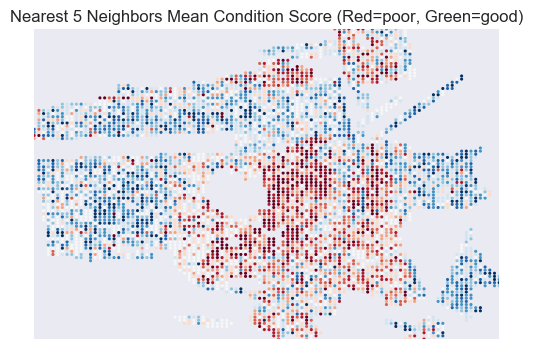

In [24]:
# Get condition scores across the city
dists, nearest_trees = knn.query(grid, k=5)
condition = []
for row in range(nearest_trees.shape[0]):
    condition.append(df_tree_cond.iloc[nearest_trees[row, :]].condition_score.mean())
condition = np.array(condition)
map_nearest_tree('Nearest 5 Neighbors Mean Condition Score (Red=poor, Green=good)',
                 condition, dists.min(axis=1), cmap='RdBu')

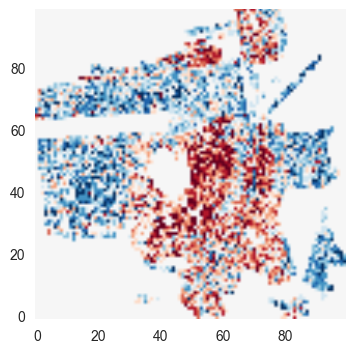

In [25]:
condition[dists.min(axis=1) > 0.001] = 0
plt.imshow(condition.reshape(N, N), cmap='RdBu', origin='lower')
plt.grid(None)

## Species Recommendations

Recommend best scoring species of local species 

Magnolia grandiflora                   462
Arbutus 'Marina'                       288
Arbutus x marina                       269
Tristaniopsis laurina                  223
Ginkgo biloba                          219
Prunus serrulata                       206
Tristania laurina                      199
Washingtonia robusta                   196
Olea europaea                          181
Cordyline australis                    176
Eriobotrya deflexa                     169
Tristania conferta                     148
Prunus cerasifera                      137
Callistemon citrinus                   135
Lagunaria patersonia                   134
Washingtonia filifera                  131
Prunus serrulata 'Kwanzan'             107
Syagrus romanzoffianum                 101
Tristaniopsis laurina 'Elegant'         98
Lophostemon confertus                   95
Syagrus romanzoffiana                   95
Magnolia grandiflora 'Little Gem'       92
Acer palmatum                           91
Platanus X 

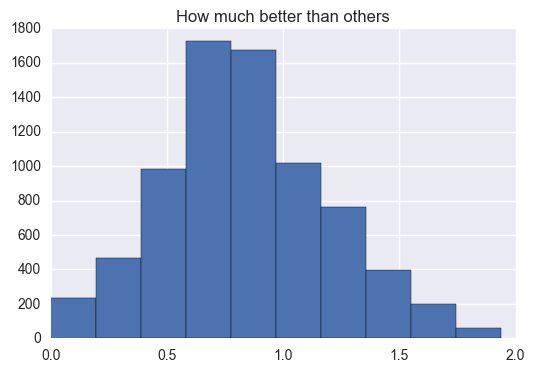

In [47]:
# Get condition scores across the city
dists, nearest_trees = knn.query(grid, k=50)

# Keep recommendation spots that are close enough to existing trees
nearest_trees = nearest_trees[dists.mean(axis=1) < 0.005]

# Extract best performant species
species = []
how_much_better = []
for row in range(nearest_trees.shape[0]):
    df_pick = pd.DataFrame()
    local_trees = df_tree_cond.iloc[nearest_trees[row, :]]
    df_pick['condition'] = local_trees.groupby('scientific_species_name').mean().condition_score
    df_pick['count'] = local_trees.groupby('scientific_species_name').count().condition_score
    
    pick = df_pick.sort_values(['condition', 'count'], ascending=False).head()
    species.append(pick.index[0])
    others = local_trees[local_trees.scientific_species_name != pick.index[0]]
    diff = pick.condition.values[0] - others.condition_score.mean()
    if np.isnan(diff):
        diff = 0
    how_much_better.append(diff)

plt.hist(how_much_better)
plt.title('How much better than others')
pd.Series(species).value_counts()